# RUN PERFORMANCE PROJECT - Pau Sampietro

## Time Series Approach for predicting future 10 km races

In this file, we focus on some specific data, those flat moves whose lenghts are between 7 and 13 km. We want to know how the moving time for these moves is evolving with time. That could provides us a more accurate prediction for similar competitions

In [19]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['text.color'] = 'k'
from rpdb import read_table, read_table_sql, export_table

#### Import moves from the database

In [98]:
Ssql = "SELECT * FROM moves WHERE athlete = 'A'"
moves = read_table_sql('moves', Ssql)
moves.head()

,index,move,start_time,distance,calories,athlete,accum_ascent,moving_time,pace,heart_rate,ascent_ratio
0,143,144,2016-03-29 23:09:21,6860.0,491.0,A,53.0,25.6,3.73,150.0,7.7
1,144,145,2016-03-31 23:06:27,11388.0,851.0,A,42.0,52.5,4.61,150.0,3.7
2,145,146,2016-04-02 13:10:33,23925.0,1858.0,A,132.0,111.5,4.66,150.0,5.5
3,146,147,2016-04-03 13:59:45,19967.0,1521.0,A,95.0,92.7,4.64,150.0,4.8
4,147,148,2016-04-07 09:38:32,10309.0,745.0,A,4.0,47.4,4.60,150.0,0.4


### 1. Filtering by distance, checking data interval and sorting moves

#### 1.1. We get only the flat moves within 7 and 13 km (10+/-3)

In [128]:
moves_ts = moves[(moves.distance >= 7000) & (moves.distance <= 13000) & (moves.ascent_ratio < 25)]
len(moves_ts)

178

#### 1.2. Preparing data: sort values, reindex, drop all but start_time & pace

In [129]:
moves_ts['start_time'].min(), moves_ts['start_time'].max()

(Timestamp('2016-03-31 23:06:27'), Timestamp('2019-04-06 13:41:02'))

* Droping all but useful time series columns, checking NaN values

In [130]:
cols = ['index', 'move','distance', 'calories', 'athlete', 'accum_ascent', 'moving_time', 'heart_rate', 'ascent_ratio']
moves_ts.drop(cols, axis=1, inplace=True)
moves_ts = moves_ts.sort_values('start_time')
moves_ts.isnull().sum()

start_time    0
pace          0
dtype: int64

In [131]:
moves_ts.set_index('start_time', inplace=True)

In [132]:
moves_ts.head()

,pace
start_time,
2016-03-31 23:06:27,4.61
2016-04-07 09:38:32,4.60
2016-04-12 09:41:21,4.76
2016-04-15 23:31:05,4.60
2016-04-25 17:37:03,5.56


* Resampling with a **Monthly interval**, interpolating pace for missing months

In [133]:
y = moves_ts['pace'].resample('W').mean().interpolate(method='linear')
y.head()

start_time
2016-04-03    4.61
2016-04-10    4.60
2016-04-17    4.68
2016-04-24    5.12
2016-05-01    5.56
Freq: W-SUN, Name: pace, dtype: float64

### 2. Plotting Time series

#### 2.1. Plotting observed pae (min / km) during the time

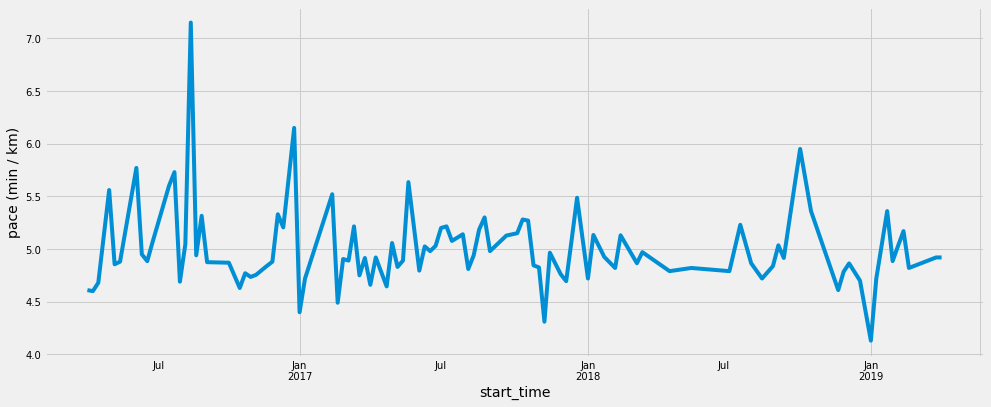

In [134]:
y.plot(figsize=(15, 6))
plt.ylabel('pace (min / km)')
plt.show()

#### 2.2. Decomposing into trend, seasonality and residual series

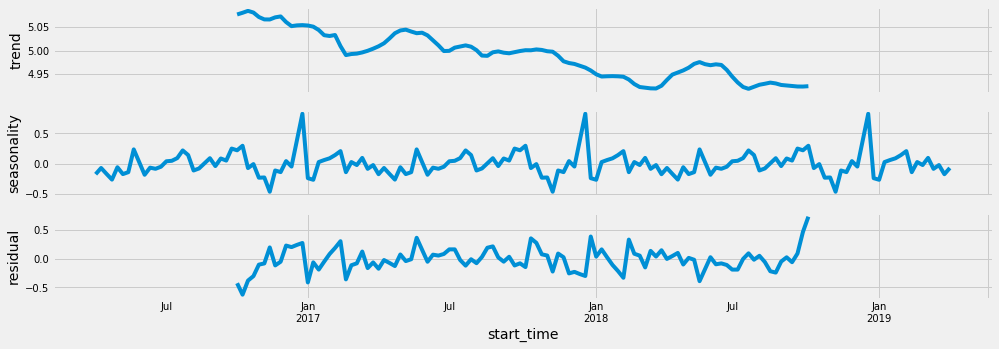

In [135]:
decomp = sm.tsa.seasonal_decompose(y, model='additive')
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,5), sharex=True)
decomp.trend.plot(ax=ax1)
ax1.set_ylabel('trend')
decomp.seasonal.plot(ax=ax2)
ax2.set_ylabel('seasonality')
decomp.resid.plot(ax=ax3)
ax3.set_ylabel('residual')
plt.show()


### 3. ARIMA Model and Pace Forecasting

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [136]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[1]}')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[2]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[3]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[4]}')

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


#### 3.1. Looking for the best parameters and applying them to the model

Here we loop trought all combinations of parameters to find the minimum AIC score which means the model fits better

In [137]:
aics = []
par = []
parsea = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            aics.append(results.aic)
            par.append(param)
            parsea.append(param_seasonal)
        except:
            continue

In [138]:
print(f'BEST AIC RESULT: {round(min(aics),1)} with: ARIMA{par[aics.index(min(aics))]}x{parsea[aics.index(min(aics))]}')

BEST AIC RESULT: 81.5 with: ARIMA(1, 1, 1)x(1, 0, 1, 12)


We can see as a minim AIC score -189, and now we take the parameters and seasonal parameters to apply to our model

#### 3.3. Fitting ARIMA model

In [139]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3546      0.047      7.501      0.000       0.262       0.447
ma.L1         -1.0000    137.437     -0.007      0.994    -270.372     268.372
ar.S.L12       0.5245      0.088      5.957      0.000       0.352       0.697
ma.S.L12      -0.7056      0.116     -6.106      0.000      -0.932      -0.479
sigma2         0.0874     12.019      0.007      0.994     -23.470      23.644


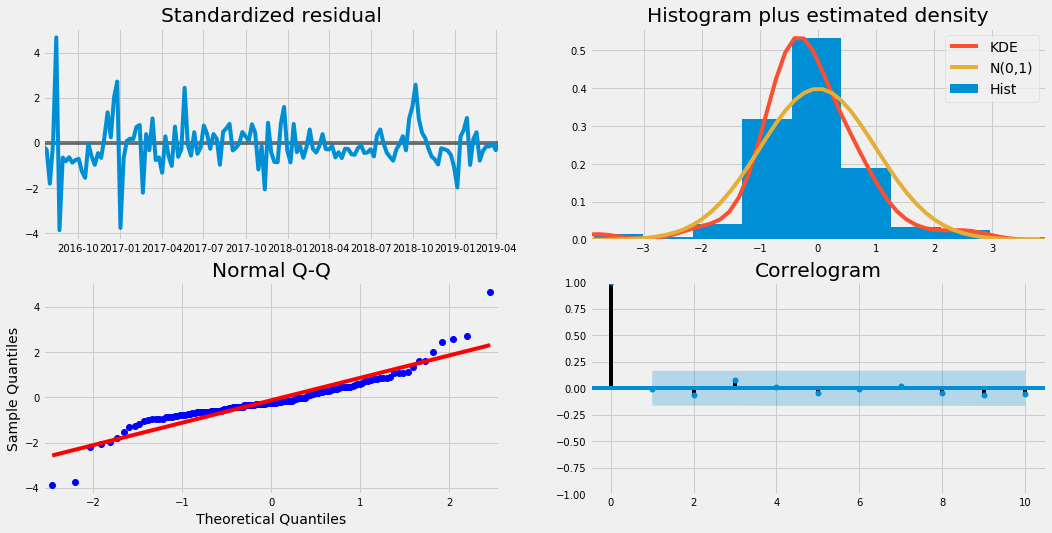

In [140]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

We could appreciate that the model is fitting okey with our data: The residuals are not perfectly normal distributed, probably because we are resampling with a 'Month' interval, and some of months we use an interpolated value because we don't have any data.

#### 3.4. Validating Forecasts

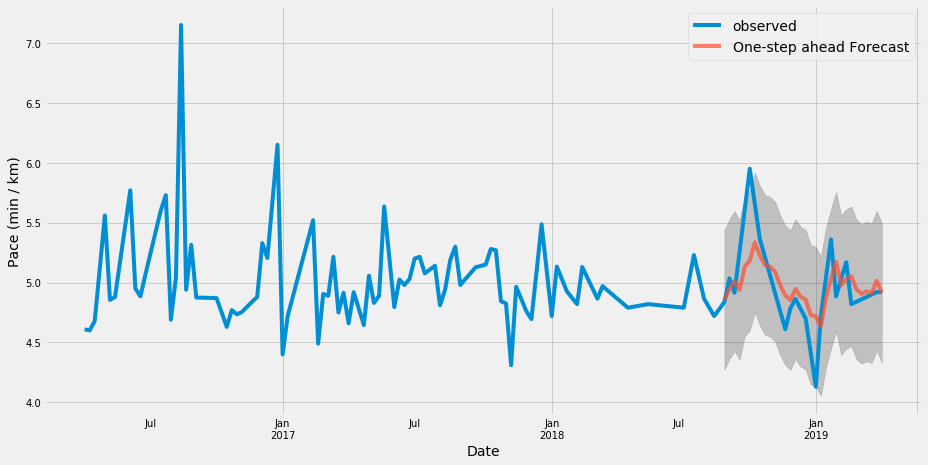

In [149]:
pred = results.get_prediction(start=pd.to_datetime('2018-9-02'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Pace (min / km)')
plt.legend()
plt.show()

We can see that the model is probably **overfitting** with given data, but will not be able to generalize as well.

* We calculate the MSE and root MSE to validate our results:

In [142]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 0.06
The Root Mean Squared Error of our forecasts is 0.25


#### 3.5. Predicting future paces for 10 km races

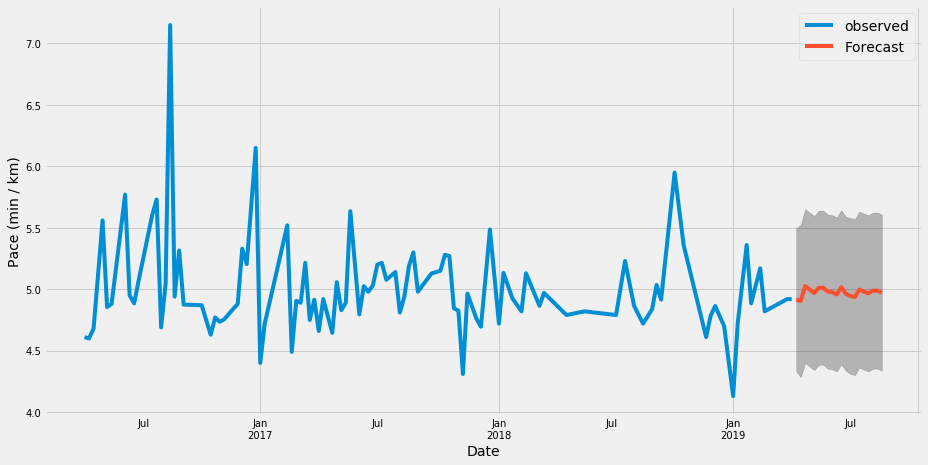

In [151]:
pred_uc = results.get_forecast(steps=20)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Pace (min / km)')
plt.legend()
plt.show()

* Confidence intervals for future paces:

In [144]:
pred_ci.head()

,lower pace,upper pace
2019-04-14,4.330671,5.496175
2019-04-21,4.284673,5.525469
2019-04-28,4.400906,5.652315
2019-05-05,4.369704,5.622959
2019-05-12,4.341906,5.595578


* Predicted paces per month:

In [160]:
pred_uc.predicted_mean[:6]

2019-04-14    4.913423
2019-04-21    4.905071
2019-04-28    5.026610
2019-05-05    4.996331
2019-05-12    4.968742
2019-05-19    5.011074
Freq: W-SUN, dtype: float64

In [168]:
round(moves_ts['pace'].mean(),2)

5.03

##### Comparing predictions with population mean for this kind of moves:

In [171]:
print(f"* TS output mean: {round(pred_uc.predicted_mean[:6].mean(),2)} // Mean Armand's moves: {round(moves_ts['pace'].mean(),2)}")

* TS output mean: 4.97 // Mean Armand's moves: 5.03


*** *COMMENTS:*** As we could see after applying this model, **the pace is not strongly time-related**. The predictions given by the ARIMA model are quite similar than the results that we can obtain doing a simple mean of the previous moves.  

Once obtained this results, now we could justify why weighting the linear regression according to how recent a move is, not provides much better results. This is because the pace does not have a clear (ascendent or descendent) trend nor seasonality